In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error

In [2]:
df = pd.read_csv('df_daily_last.csv')

In [3]:
df.head()

,date,date.1,close_sp500,close_vix,polarity_x_strong,y,ret_lag1,ret_roll5,vix_lag1,vix_chg1,polarity_x_strong_lag1,polarity_x_strong_roll3
0,2007-05-10,2007-05-10,1491.469971,13.60,0.000000,-0.007268,0.010826,0.007889,-0.031088,0.038961,0.999995,0.666031
1,2007-05-22,2007-05-22,1524.119995,13.06,0.999803,0.021891,-0.007268,0.003151,0.038961,-0.039706,0.000000,0.333332
2,2007-05-30,2007-05-30,1530.229980,12.83,0.917965,0.004009,0.021891,0.007203,-0.039706,-0.017611,0.999803,0.666599
3,2007-07-13,2007-07-13,1552.500000,15.15,0.000000,0.014553,0.004009,0.006422,-0.017611,0.180826,0.917965,0.639256
4,2007-07-18,2007-07-18,1546.170044,16.00,0.000000,-0.004077,0.014553,0.008802,0.180826,0.056106,0.000000,0.639256


In [4]:
for lag in range(1, 6):
    df[f'polarity_x_strong_lag{lag}'] = df['polarity_x_strong_lag1'].shift(lag)
    df[f'vix_lag{lag}'] = df['vix_lag1'].shift(lag)
    df[f'y_lag{lag}'] = df['y'].shift(lag)

df_model = df.dropna(subset=[f'y_lag{lag}' for lag in range(1, 6)] + [f'vix_lag{lag}'] + [f'polarity_x_strong_lag{lag}' for lag in range(1, 6)] + ['y'])

In [7]:
# Without sentiment

X = df_model[[f'y_lag{lag}' for lag in range(1, 6)] + ['vix_chg1']]
y = df_model['y']

mse_lin, mse_ridge, mse_lasso = [], [], []
mae_lin, mae_ridge, mae_lasso = [], [], []
indices = []
window = 50
y_pred_lin_all, y_pred_ridge_all, y_pred_lasso_all = [], [], []
y_true_all = []
dates_all = []

for i in range(window, len(X)):
    if i >= len(X):
        break
    X_train = X.iloc[:i]
    y_train = y.iloc[:i]
    X_test = X.iloc[i:i+1]
    y_test = y.iloc[i:i+1]

    if X_test.empty or y_test.empty:
        continue

    model_lin = LinearRegression().fit(X_train, y_train)
    model_ridge = Ridge().fit(X_train, y_train)
    model_lasso = Lasso(alpha=0.0001).fit(X_train, y_train)

    y_pred_lin, y_pred_ridge, y_pred_lasso = model_lin.predict(X_test), model_ridge.predict(X_test), model_lasso.predict(X_test)
    y_pred_lin_all.append(y_pred_lin)
    y_pred_ridge_all.append(y_pred_ridge)
    y_pred_lasso_all.append(y_pred_lasso)

    y_true_all.append(y_test.values[0])
    dates_all.append(df_model.iloc[i]['date']) 

    mse_lin.append(mean_squared_error(y_test, y_pred_lin))
    mae_lin.append(mean_absolute_error(y_test, y_pred_lin))

    mse_ridge.append(mean_squared_error(y_test, y_pred_ridge))
    mae_ridge.append(mean_absolute_error(y_test, y_pred_ridge))

    mse_lasso.append(mean_squared_error(y_test, y_pred_lasso))
    mae_lasso.append(mean_absolute_error(y_test, y_pred_lasso))

    indices.append(i)

y_pred_lin_wo = pd.Series(y_pred_lin_all, index=pd.to_datetime(dates_all))
y_pred_ridge_wo = pd.Series(y_pred_ridge_all, index=pd.to_datetime(dates_all))
y_pred_lasso_wo = pd.Series(y_pred_lasso_all, index=pd.to_datetime(dates_all))

y_true_wo = pd.Series(y_true_all, index=pd.to_datetime(dates_all))

print(f"Linear Regression without sentiment\nMAE: {np.mean(mae_lin)}\nMSE: {np.mean(mse_lin)}\n\n\
      Ridge Regression without sentiment\nMAE: {np.mean(mae_ridge)}\nMSE: {np.mean(mse_ridge)}\n\n\
        Lasso Regression without sentiment\nMAE: {np.mean(mae_lasso)}\nMSE: {np.mean(mse_lasso)}")

Linear Regression without sentiment
MAE: 0.007944204652578998
MSE: 0.0002106040427950316

      Ridge Regression without sentiment
MAE: 0.007559643412642185
MSE: 0.00019163054727098385

        Lasso Regression without sentiment
MAE: 0.0076565933380315565
MSE: 0.0001942692270465647


In [10]:
# With sentiment

X = df_model[[f'y_lag{lag}' for lag in range(1, 6)] + ['vix_chg1', 'polarity_x_strong_lag1', 'polarity_x_strong_roll3']]
y = df_model['y']

mse_lin, mse_ridge, mse_lasso = [], [], []
mae_lin, mae_ridge, mae_lasso = [], [], []
indices = []
window = 50
y_pred_lin_all, y_pred_ridge_all, y_pred_lasso_all = [], [], []
y_true_all = []
dates_all = []

for i in range(window, len(X)):
    if i >= len(X):
        break
    X_train = X.iloc[:i]
    y_train = y.iloc[:i]
    X_test = X.iloc[i:i+1]
    y_test = y.iloc[i:i+1]

    if X_test.empty or y_test.empty:
        continue

    model_lin = LinearRegression().fit(X_train, y_train)
    model_ridge = Ridge().fit(X_train, y_train)
    model_lasso = Lasso(alpha=0.0001).fit(X_train, y_train)

    y_pred_lin, y_pred_ridge, y_pred_lasso = model_lin.predict(X_test), model_ridge.predict(X_test), model_lasso.predict(X_test)
    y_pred_lin_all.append(y_pred_lin)
    y_pred_ridge_all.append(y_pred_ridge)
    y_pred_lasso_all.append(y_pred_lasso)

    y_true_all.append(y_test.values[0])
    dates_all.append(df_model.iloc[i]['date']) 

    mse_lin.append(mean_squared_error(y_test, y_pred_lin))
    mae_lin.append(mean_absolute_error(y_test, y_pred_lin))

    mse_ridge.append(mean_squared_error(y_test, y_pred_ridge))
    mae_ridge.append(mean_absolute_error(y_test, y_pred_ridge))

    mse_lasso.append(mean_squared_error(y_test, y_pred_lasso))
    mae_lasso.append(mean_absolute_error(y_test, y_pred_lasso))

    indices.append(i)

y_pred_lin_with = pd.Series(y_pred_lin_all, index=pd.to_datetime(dates_all))
y_pred_ridge_with = pd.Series(y_pred_ridge_all, index=pd.to_datetime(dates_all))
y_pred_lasso_with = pd.Series(y_pred_lasso_all, index=pd.to_datetime(dates_all))

y_true_with = pd.Series(y_true_all, index=pd.to_datetime(dates_all))

print(f"Linear Regression with sentiment\nMAE: {np.mean(mae_lin)}\nMSE: {np.mean(mse_lin)}\n\n\
      Ridge Regression with sentiment\nMAE: {np.mean(mae_ridge)}\nMSE: {np.mean(mse_ridge)}\n\n\
        Lasso Regression with sentiment\nMAE: {np.mean(mae_lasso)}\nMSE: {np.mean(mse_lasso)}")

Linear Regression with sentiment
MAE: 0.008028980598041238
MSE: 0.00021291671816640317

      Ridge Regression with sentiment
MAE: 0.007710117047906141
MSE: 0.00019438242623464613

        Lasso Regression with sentiment
MAE: 0.00771112474490875
MSE: 0.00019528345163246237


In [11]:
# Linear Regression with lagged sentiment

X = df_model[[f'y_lag{lag}' for lag in range(1, 6)] + [f'polarity_x_strong_lag{lag}' for lag in range(1, 6)] +\
             ['vix_chg1', 'polarity_x_strong_roll3']]
y = df_model['y']

mse_lin, mse_ridge, mse_lasso = [], [], []
mae_lin, mae_ridge, mae_lasso = [], [], []
indices = []
window = 50
y_pred_lin_all, y_pred_ridge_all, y_pred_lasso_all = [], [], []
y_true_all = []
dates_all = []

for i in range(window, len(X)):
    if i >= len(X):
        break
    X_train = X.iloc[:i]
    y_train = y.iloc[:i]
    X_test = X.iloc[i:i+1]
    y_test = y.iloc[i:i+1]

    if X_test.empty or y_test.empty:
        continue

    model_lin = LinearRegression().fit(X_train, y_train)
    model_ridge = Ridge().fit(X_train, y_train)
    model_lasso = Lasso(alpha=0.0001).fit(X_train, y_train)

    y_pred_lin, y_pred_ridge, y_pred_lasso = model_lin.predict(X_test), model_ridge.predict(X_test), model_lasso.predict(X_test)
    y_pred_lin_all.append(y_pred_lin)
    y_pred_ridge_all.append(y_pred_ridge)
    y_pred_lasso_all.append(y_pred_lasso)

    y_true_all.append(y_test.values[0])
    dates_all.append(df_model.iloc[i]['date']) 

    mse_lin.append(mean_squared_error(y_test, y_pred_lin))
    mae_lin.append(mean_absolute_error(y_test, y_pred_lin))

    mse_ridge.append(mean_squared_error(y_test, y_pred_ridge))
    mae_ridge.append(mean_absolute_error(y_test, y_pred_ridge))

    mse_lasso.append(mean_squared_error(y_test, y_pred_lasso))
    mae_lasso.append(mean_absolute_error(y_test, y_pred_lasso))

    indices.append(i)

y_pred_lin_lag = pd.Series(y_pred_lin_all, index=pd.to_datetime(dates_all))
y_pred_ridge_lag = pd.Series(y_pred_ridge_all, index=pd.to_datetime(dates_all))
y_pred_lasso_lag = pd.Series(y_pred_lasso_all, index=pd.to_datetime(dates_all))

y_true_lag = pd.Series(y_true_all, index=pd.to_datetime(dates_all))

print(f"Linear Regression with lagged sentiment\nMAE: {np.mean(mae_lin)}\nMSE: {np.mean(mse_lin)}\n\n\
      Ridge Regression with lagged sentiment\nMAE: {np.mean(mae_ridge)}\nMSE: {np.mean(mse_ridge)}\n\n\
        Lasso Regression with lagged sentiment\nMAE: {np.mean(mae_lasso)}\nMSE: {np.mean(mse_lasso)}")

Linear Regression with lagged sentiment
MAE: 0.008183437914344126
MSE: 0.00021743233423108306

      Ridge Regression with lagged sentiment
MAE: 0.007832309486613962
MSE: 0.00019788349688809083

        Lasso Regression with lagged sentiment
MAE: 0.0077884939403914544
MSE: 0.00019783647462025004


### Grid search

In [22]:
# Ridge Regression

alpha_grid = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
best_alpha = None
best_mae = float('inf')
metrics_by_alpha = {}

X_wo_sent = df_model[[f'y_lag{lag}' for lag in range(1, 6)] + ['vix_lag1']]
X_sent = df_model[[f'y_lag{lag}' for lag in range(1, 6)] + ['vix_lag1', 'polarity_x_strong_lag1', 'polarity_x_strong_roll3']]
X_sent_lagged = df_model[[f'y_lag{lag}' for lag in range(1, 6)] + [f'polarity_x_strong_lag{lag}' for lag in range(1, 6)] +\
             ['vix_lag1', 'polarity_x_strong_roll3']]

y_full = df_model['y']
window = 50

n = len(X_sent)
if n != len(X_wo_sent) or n != len(X_sent_lagged):
    ValueError

for alpha in alpha_grid:
    mse_list_wo_sent, mae_list_wo_sent, rmse_list_wo_sent = [], [], []
    mse_list_sent, mae_list_sent, rmse_list_sent = [], [], []
    mse_list_sent_lag, mae_list_sent_lag, rmse_list_sent_lag = [], [], []
    
    for i in range(window, n):
        if i >= len(X):
            break

        X_train = X_wo_sent.iloc[:i]
        y_train = y_full.iloc[:i]
        X_test = X_wo_sent.iloc[i:i+1]
        y_test = y_full.iloc[i:i+1]

        if X_test.empty or y_test.empty:
            continue

        model = Ridge(alpha=alpha).fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = root_mean_squared_error(y_test, y_pred)

        mse_list_wo_sent.append(mse)
        mae_list_wo_sent.append(mae)
        rmse_list_wo_sent.append(rmse)

        X_train = X_sent.iloc[:i]
        y_train = y_full.iloc[:i]
        X_test = X_sent.iloc[i:i+1]
        y_test = y_full.iloc[i:i+1]

        if X_test.empty or y_test.empty:
            continue

        model = Ridge(alpha=alpha).fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = root_mean_squared_error(y_test, y_pred)

        mse_list_sent.append(mse)
        mae_list_sent.append(mae)
        rmse_list_sent.append(rmse)

        X_train = X_sent_lagged.iloc[:i]
        y_train = y_full.iloc[:i]
        X_test = X_sent_lagged.iloc[i:i+1]
        y_test = y_full.iloc[i:i+1]

        if X_test.empty or y_test.empty:
            continue

        model = Ridge(alpha=alpha).fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = root_mean_squared_error(y_test, y_pred)

        mse_list_sent_lag.append(mse)
        mae_list_sent_lag.append(mae)
        rmse_list_sent_lag.append(rmse)

    metrics_by_alpha[alpha] = {
        'mse_wo': np.mean(mse_list_wo_sent),
        'mae_wo': np.mean(mae_list_wo_sent),
        'rmse_wo': np.mean(rmse_list_wo_sent),
        'mse_wo_list': mse_list_wo_sent,
        'mae_wo_list': mae_list_wo_sent,
        'rmse_wo_list': rmse_list_wo_sent,
        'mse': np.mean(mse_list_sent),
        'mae': np.mean(mae_list_sent),
        'rmse': np.mean(rmse_list_sent),
        'mse_list': mse_list_sent,
        'mae_list': mae_list_sent,
        'rmse_list': rmse_list_sent,
        'mse_lag': np.mean(mse_list_sent_lag),
        'mae_lag': np.mean(mae_list_sent_lag),
        'rmse_lag': np.mean(rmse_list_sent_lag),
        'mse_lag_list': mse_list_sent_lag,
        'mae_lag_list': mae_list_sent_lag,
        'rmse_lag_list': rmse_list_sent_lag,
    }


In [23]:
for alpha in metrics_by_alpha.keys():
    print(f"Alpha = {alpha}\nWithout sentiment:\nMAE = {metrics_by_alpha[alpha]['mae_wo']}\nMSE = {metrics_by_alpha[alpha]['mse_wo']}\n")
    print(f"Alpha = {alpha}\nWith sentiment:\nMAE = {metrics_by_alpha[alpha]['mae']}\nMSE = {metrics_by_alpha[alpha]['mse']}\n")
    print(f"Alpha = {alpha}\nWith lagged sentiment:\nMAE = {metrics_by_alpha[alpha]['mae_lag']}\nMSE = {metrics_by_alpha[alpha]['mse_lag']}\n")

Alpha = 0.001
Without sentiment:
MAE = 0.011194326372066259
MSE = 0.0003697720454561767

Alpha = 0.001
With sentiment:
MAE = 0.011361267720793971
MSE = 0.0003773711692770981

Alpha = 0.001
With lagged sentiment:
MAE = 0.011567556953807318
MSE = 0.0003840978257706818

Alpha = 0.01
Without sentiment:
MAE = 0.011117455734794321
MSE = 0.0003595243755334866

Alpha = 0.01
With sentiment:
MAE = 0.01128499524507302
MSE = 0.00036673662988881065

Alpha = 0.01
With lagged sentiment:
MAE = 0.011482491028669821
MSE = 0.0003731148142230134

Alpha = 0.1
Without sentiment:
MAE = 0.010946162100668514
MSE = 0.00034103884033934346

Alpha = 0.1
With sentiment:
MAE = 0.011105880406858554
MSE = 0.00034718877403731835

Alpha = 0.1
With lagged sentiment:
MAE = 0.011290154063708818
MSE = 0.00035330420449297776

Alpha = 1.0
Without sentiment:
MAE = 0.010903764876157053
MSE = 0.00033372783588308527

Alpha = 1.0
With sentiment:
MAE = 0.011037863869162168
MSE = 0.0003383851616473397

Alpha = 1.0
With lagged sentim

In [24]:
# Lasso Regression

alpha_grid = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
best_alpha = None
best_mae = float('inf')
metrics_by_alpha = {}

df_model = df.dropna(subset=[f'y_lag{lag}' for lag in range(1, 6)] + [f'polarity_x_strong_lag{lag}' for lag in range(1, 6)] + ['y'])

X_wo_sent = df_model[[f'y_lag{lag}' for lag in range(1, 6)] + ['vix_chg1']]
X_sent = df_model[[f'y_lag{lag}' for lag in range(1, 6)] + ['vix_chg1', 'polarity_x_strong_lag1', 'polarity_x_strong_roll3']]
X_sent_lagged = df_model[[f'y_lag{lag}' for lag in range(1, 6)] + [f'polarity_x_strong_lag{lag}' for lag in range(1, 6)] +\
             ['vix_chg1', 'polarity_x_strong_roll3']]

y_full = df_model['y']
window = 50

n = len(X_sent)
if n != len(X_wo_sent) or n != len(X_sent_lagged):
    ValueError


for alpha in alpha_grid:
    mse_list_wo_sent, mae_list_wo_sent, rmse_list_wo_sent = [], [], []
    mse_list_sent, mae_list_sent, rmse_list_sent = [], [], []
    mse_list_sent_lag, mae_list_sent_lag, rmse_list_sent_lag = [], [], []
    
    for i in range(window, n):
        if i >= len(X):
            break

        # without sentiment
        X_train = X_wo_sent.iloc[:i]
        y_train = y_full.iloc[:i]
        X_test = X_wo_sent.iloc[i:i+1]
        y_test = y_full.iloc[i:i+1]

        if X_test.empty or y_test.empty:
            continue

        model = Lasso(alpha=alpha).fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = root_mean_squared_error(y_test, y_pred)

        mse_list_wo_sent.append(mse)
        mae_list_wo_sent.append(mae)
        rmse_list_wo_sent.append(rmse)

        # with sentiment
        X_train = X_sent.iloc[:i]
        y_train = y_full.iloc[:i]
        X_test = X_sent.iloc[i:i+1]
        y_test = y_full.iloc[i:i+1]

        if X_test.empty or y_test.empty:
            continue

        model = Lasso(alpha=alpha).fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = root_mean_squared_error(y_test, y_pred)

        mse_list_sent.append(mse)
        mae_list_sent.append(mae)
        rmse_list_sent.append(rmse)

        # with lagged sentiment
        X_train = X_sent_lagged.iloc[:i]
        y_train = y_full.iloc[:i]
        X_test = X_sent_lagged.iloc[i:i+1]
        y_test = y_full.iloc[i:i+1]

        if X_test.empty or y_test.empty:
            continue

        model = Lasso(alpha=alpha).fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = root_mean_squared_error(y_test, y_pred)

        mse_list_sent_lag.append(mse)
        mae_list_sent_lag.append(mae)
        rmse_list_sent_lag.append(rmse)

    metrics_by_alpha[alpha] = {
        'mse_wo': np.mean(mse_list_wo_sent),
        'mae_wo': np.mean(mae_list_wo_sent),
        'rmse_wo': np.mean(rmse_list_wo_sent),
        'mse_wo_list': mse_list_wo_sent,
        'mae_wo_list': mae_list_wo_sent,
        'rmse_wo_list': rmse_list_wo_sent,
        'mse': np.mean(mse_list_sent),
        'mae': np.mean(mae_list_sent),
        'rmse': np.mean(rmse_list_sent),
        'mse_list': mse_list_sent,
        'mae_list': mae_list_sent,
        'rmse_list': rmse_list_sent,
        'mse_lag': np.mean(mse_list_sent_lag),
        'mae_lag': np.mean(mae_list_sent_lag),
        'rmse_lag': np.mean(rmse_list_sent_lag),
        'mse_lag_list': mse_list_sent_lag,
        'mae_lag_list': mae_list_sent_lag,
        'rmse_lag_list': rmse_list_sent_lag,
    }


In [25]:
for alpha in metrics_by_alpha.keys():
    print(f"Alpha = {alpha}\nWithout sentiment:\nMAE = {metrics_by_alpha[alpha]['mae_wo']}\nMSE = {metrics_by_alpha[alpha]['mse_wo']}\n")
    print(f"Alpha = {alpha}\nWith sentiment:\nMAE = {metrics_by_alpha[alpha]['mae']}\nMSE = {metrics_by_alpha[alpha]['mse']}\n")
    print(f"Alpha = {alpha}\nWith lagged sentiment:\nMAE = {metrics_by_alpha[alpha]['mae_lag']}\nMSE = {metrics_by_alpha[alpha]['mse_lag']}\n")

Alpha = 0.0001
Without sentiment:
MAE = 0.0076565933380315565
MSE = 0.0001942692270465647

Alpha = 0.0001
With sentiment:
MAE = 0.00771112474490875
MSE = 0.00019528345163246237

Alpha = 0.0001
With lagged sentiment:
MAE = 0.0077884939403914544
MSE = 0.00019783647462025004

Alpha = 0.001
Without sentiment:
MAE = 0.007883565605107236
MSE = 0.0001890105496457227

Alpha = 0.001
With sentiment:
MAE = 0.007894759259120702
MSE = 0.00018928196808808771

Alpha = 0.001
With lagged sentiment:
MAE = 0.007898354303550922
MSE = 0.0001897789881927608

Alpha = 0.01
Without sentiment:
MAE = 0.010886285351001222
MSE = 0.0003317130395036765

Alpha = 0.01
With sentiment:
MAE = 0.010886285351001222
MSE = 0.0003317130395036765

Alpha = 0.01
With lagged sentiment:
MAE = 0.010886285351001222
MSE = 0.0003317130395036765

Alpha = 0.1
Without sentiment:
MAE = 0.010886285351001222
MSE = 0.0003317130395036765

Alpha = 0.1
With sentiment:
MAE = 0.010886285351001222
MSE = 0.0003317130395036765

Alpha = 0.1
With lagg

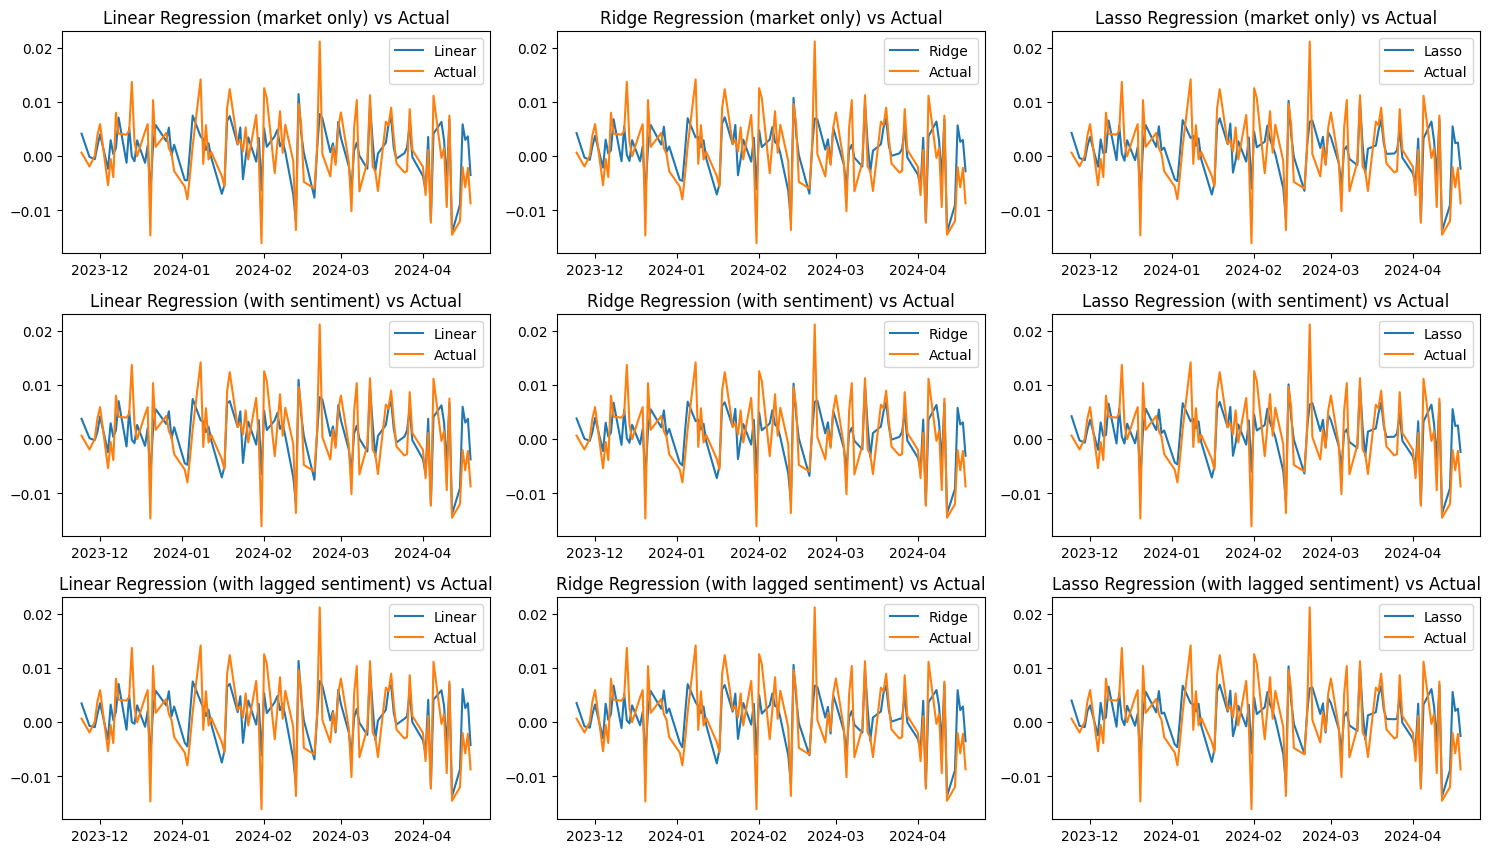

In [26]:
fig, ax = plt.subplots(3, 3, figsize=(15, 9))

ax[0, 0].plot(y_pred_lin_wo[-100:], label='Linear')
ax[0, 0].plot(y_true_wo[-100:], label='Actual')
ax[0, 0].set_title("Linear Regression (market only) vs Actual")
ax[0, 0].legend()

ax[1, 0].plot(y_pred_lin_with[-100:], label='Linear')
ax[1, 0].plot(y_true_with[-100:], label='Actual')
ax[1, 0].set_title("Linear Regression (with sentiment) vs Actual")
ax[1, 0].legend()

ax[2, 0].plot(y_pred_lin_lag[-100:], label='Linear')
ax[2, 0].plot(y_true_lag[-100:], label='Actual')
ax[2, 0].set_title("Linear Regression (with lagged sentiment) vs Actual")
ax[2, 0].legend()


ax[0, 1].plot(y_pred_ridge_wo[-100:], label='Ridge')
ax[0, 1].plot(y_true_wo[-100:], label='Actual')
ax[0, 1].set_title("Ridge Regression (market only) vs Actual")
ax[0, 1].legend()

ax[1, 1].plot(y_pred_ridge_with[-100:], label='Ridge')
ax[1, 1].plot(y_true_with[-100:], label='Actual')
ax[1, 1].set_title("Ridge Regression (with sentiment) vs Actual")
ax[1, 1].legend()

ax[2, 1].plot(y_pred_ridge_lag[-100:], label='Ridge')
ax[2, 1].plot(y_true_lag[-100:], label='Actual')
ax[2, 1].set_title("Ridge Regression (with lagged sentiment) vs Actual")
ax[2, 1].legend()


ax[0, 2].plot(y_pred_lasso_wo[-100:], label='Lasso')
ax[0, 2].plot(y_true_wo[-100:], label='Actual')
ax[0, 2].set_title("Lasso Regression (market only) vs Actual")
ax[0, 2].legend()

ax[1, 2].plot(y_pred_lasso_with[-100:], label='Lasso')
ax[1, 2].plot(y_true_with[-100:], label='Actual')
ax[1, 2].set_title("Lasso Regression (with sentiment) vs Actual")
ax[1, 2].legend()

ax[2, 2].plot(y_pred_lasso_lag[-100:], label='Lasso')
ax[2, 2].plot(y_true_lag[-100:], label='Actual')
ax[2, 2].set_title("Lasso Regression (with lagged sentiment) vs Actual")
ax[2, 2].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])